In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 331, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 331 (delta 36), reused 36 (delta 14), pack-reused 256 (from 1)
Receiving objects: 100% (331/331), 10.73 MiB | 15.83 MiB/s, done.
Resolving deltas: 100% (183/183), done.
/content/bsc-thesis/src
backtesting/  data/       main.py  preprocessing/
config/       main.ipynb  models/  utils/


In [2]:
!pip install ta
!pip install prophet
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c8fca42416f4344070a4d09c73333d18af1144473072b61eae4ea07235ddb376
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 12.8 MB/s eta 0:00:00


In [3]:
## specific packages for time moe
!pip install accelerate==0.28.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [4]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler # TODO: import not needed?
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch.nn as nn
import itertools
from transformers import AutoModelForCausalLM # contains Time MoE model
import transformers

# Custom Imports
from models.statistical_models import create_dataset
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from models.statistical_models import default_normalize
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.sliding_window import create_sliding_dataset, SlidingWindowDataset

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached


# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

# OPTIONAL: checking whether a specific function is the version you want or not
inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(find_cointegrated_pairs)) # in this case, check whether tqdm was actually added

In [5]:
### Configs - change these to the desired values to LOAD FROM cache as wanted
startDateStr = '2010-10-01'
endDateStr = '2024-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
# Note about pairs_timeseries_df: the timeseries output on which we should train are found in the key "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

Processing pairs: 100%|██████████| 1711/1711 [06:40<00:00,  4.27it/s]


Completed 1711 pairs


/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

In [109]:
hard_code_pair = True
if hard_code_pair:
  print([pair for pair in pairs_data_filtered if "SQQQ" not in pair[0]])
  # [(('IEI', 'VCIT'), np.float64(0.0001730364093693033)),
  ticker_a = "IEI"
  ticker_b = "VCIT"
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

[(('IEI', 'VCIT'), np.float64(0.0001730364093693033)), (('MBB', 'VMBS'), np.float64(0.0003024652925735093)), (('PRFZ', 'INDY'), np.float64(0.0004460099749179781)), (('INDY', 'FEX'), np.float64(0.00045858319738158534)), (('PKW', 'INDY'), np.float64(0.0007711267673051065)), (('ACWI', 'INDY'), np.float64(0.0010081253492203685)), (('IJT', 'INDY'), np.float64(0.0021123388240424637)), (('VCLT', 'IEI'), np.float64(0.002162051916119)), (('VTWO', 'INDY'), np.float64(0.0023178308630730105)), (('INDY', 'IUSG'), np.float64(0.002612143248094905)), (('IUSV', 'INDY'), np.float64(0.0033319213505387116)), (('IGIB', 'IEI'), np.float64(0.0035716594122520784)), (('QTEC', 'INDY'), np.float64(0.0036205956608537848)), (('INDY', 'FTCS'), np.float64(0.0037710087428682363)), (('MBB', 'VGSH'), np.float64(0.003965510308683095)), (('INDY', 'VONV'), np.float64(0.004247915117486323)), (('IGIB', 'SHY'), np.float64(0.004567799305918318)), (('USIG', 'SHY'), np.float64(0.00457522558439541)), (('VCLT', 'TLT'), np.float64

/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

In [110]:
# Set a bunch of variables based on the existing functions `execute_kalman_workflow` and `execute_transformer_workflow` (Note: Some are changed already)
pairs_timeseries: pd.DataFrame = pairs_timeseries_df
target_col: str = "Spread_Close"
burn_in: int = 30 # we remove the first 30 elements, because the largest window used for technical indicators is
train_frac: float = 0.90
dev_frac: float = 0.05   # remaining part is test
look_back: int = 20
batch_size: int = 8
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
plot_results: bool = True
return_datasets: bool = False
verbose: bool = True

# Notes:
# - Chose not to use wavelet denoising for this, as it was also not done in the original time-moe code. Perhaps it could be useful to compare the inclusion to the exclusion of wavelet denoising if time is available.


Split sizes — train: 3143, dev: 174, test: 176
devX_raw Shape: torch.Size([154, 20])
dev_loader tensor Shape: torch.Size([8, 20]), with a total of 20 batches


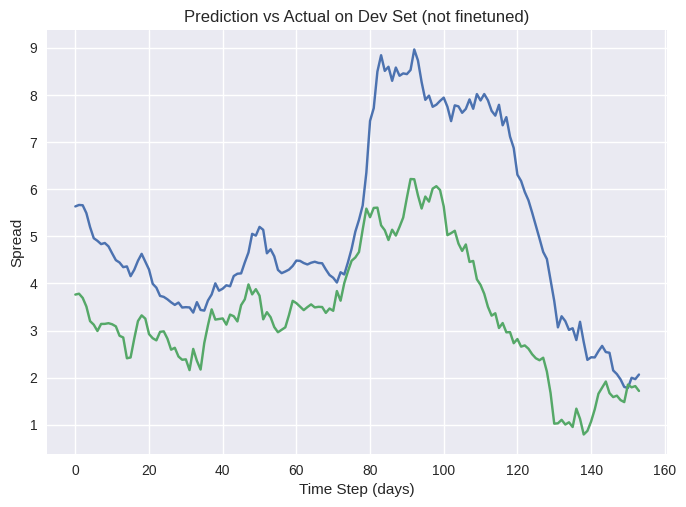

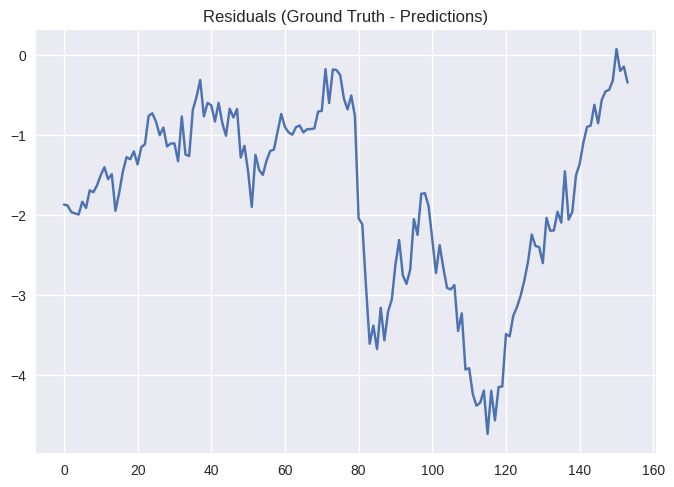

---RESULTS---
Dev MSE: 4.349771499633789
(154,)
(154,)


In [115]:
# def execute_timemoe_workflow(...):
if not target_col in pairs_timeseries.columns:
  raise KeyError(f"pairs_timeseries must contain {target_col}")

# burn the first 30 elements
pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

total_len = len(pairs_timeseries_burned)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

# Standard version of the Time-MoE model can only take in univariate time series. Therefore, we will train only on the target_col
# TODO: Convert to using multivariate again, a certain type of "multivariate" processing is possible according to the original time-moe paper, but not the version we would want to use. It is not possible to use many different features to enhance the prediction of the target column
pairs_timeseries_burned_univariate = pairs_timeseries_burned[target_col]

train = pairs_timeseries_burned_univariate[:train_size]
dev   = pairs_timeseries_burned_univariate[train_size:train_size+dev_size] # aka validation
test  = pairs_timeseries_burned_univariate[train_size+dev_size:]

if verbose:
    print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

# def create_sequences(series, look_back):
#     X_raw = series[:batch_size * look_back].to_numpy() # .reshape(batch_size, look_back)
#     X_raw = torch.tensor(X_raw, dtype=torch.float32)

#     # normalize devX_raw
#     mean, std = devX_raw.mean(dim=-1, keepdim=True), devX_raw.std(dim=-1, keepdim=True)
#     X_scaled = (devX_raw - mean) / std
#     return X_raw, X_scaled, None, None, mean, std
DEVICE = "cpu" #  "cuda" if torch.cuda.is_available() else "cpu"


def create_sequences_rolling(series, look_back):
    X = []
    y = []
    for i in range(len(series) - look_back):
        seq = series.iloc[i:i+look_back].values
        target = series.iloc[i+look_back]
        X.append(seq)
        y.append(target)

    X = torch.tensor(X, dtype=torch.float32)
    X = X.to(DEVICE)

    # normalize
    mean = X.mean(dim=-1, keepdim=True)
    std = X.std(dim=-1, keepdim=True)
    X_scaled = (X - mean) / (std + 1e-8)

    y = torch.tensor(y, dtype=torch.float32)
    y = y.to(DEVICE)
    return X, X_scaled, y, None, mean, std

devX_raw, devX_scaled, devY_raw, devY_scaled, dev_mean, dev_std = create_sequences_rolling(dev, look_back)
if verbose:
  print(f"devX_raw Shape: {devX_raw.shape}") # entire devX_raw has that shape before dataset and dev_loader logic

dev_ds = TensorDataset(devX_raw, devY_raw) # goal of TensorDataset class: loading and processing dataset lazily
dev_loader = DataLoader(dev_ds, batch_size=batch_size, shuffle=False) # DataLoader takes care of shuffling/sampling/weigthed sampling, batching, using multiprocessing to load the data, use pinned memory etc. (source; https://discuss.pytorch.org/t/what-do-tensordataset-and-dataloader-do/107017)

if verbose:
  print(f"dev_loader tensor Shape: {next(iter(dev_loader))[0].shape}, with a total of {len(dev_loader)} batches") # a single tensor in dev_loader now has shape [batch_size, look_back] as expected

model = AutoModelForCausalLM.from_pretrained(
    'Maple728/TimeMoE-50M',
    device_map=DEVICE,
    trust_remote_code=True,
)

if FLASH_ATTN: # if FLASH_ATTN, we assume the flash-attention module is installed, and adapt the model to use that
  model = AutoModelForCausalLM.from_pretrained('Maple728/TimeMoE-50M', device_map="auto", attn_implementation='flash_attention_2', trust_remote_code=True)

prediction_length = 1 # TODO: rather than hardcoding prediction length, make a strategy where we can pick and choose different prediction lengths, and see what is affected by this (returns, std dev, ..)

# forecast in batches from dev dataset
all_predictions = []
for i, batch in enumerate(dev_loader):
  inputs = batch[0] # is devX_scaled, for now [1] will return error, later [1] will return devY_scaled :D

  yvals = batch[1]
  # means = batch[2]
  # stds = batch[3]

  output = model.generate(inputs, max_new_tokens=prediction_length)  # shape is [batch_size, look_back + prediction_length]
  normed_predictions = output[:, -prediction_length:]  # shape is [batch_size, prediction_length]

  # from returned dev_mean and dev_std, slice the appropriate slices from the series
  input_size_current = inputs.size()
  batch_size_current = input_size_current[0]
  local_means = dev_mean[batch_size*i : batch_size*i + batch_size_current]
  local_stds = dev_std[batch_size*i : batch_size*i + batch_size_current]

  preds = normed_predictions * local_stds + local_means
  all_predictions.append(preds)

# Concatenate all predictions
predictions = torch.cat(all_predictions, dim=0)
predictions = predictions.squeeze(-1)
predictions = predictions.detach().numpy()

if plot_results:
  plt.title("Prediction vs Actual on Dev Set (not finetuned)")
  plt.xlabel("Time Step (days)")
  plt.ylabel("Spread")
  plt.legend(["Predictions", "Ground Truth"])
  plt.plot(predictions)
  plt.plot(devY_raw.numpy())
  plt.show()

  residuals = devY_raw.numpy() - predictions
  plt.plot(residuals)
  plt.title("Residuals (Ground Truth - Predictions)")
  plt.show()


test_mse = None
forecast = None
timemoe_spread = None
dev_pretrained_mse = mean_squared_error(devY_raw.numpy(), predictions)
output: Dict[str, Any] = dict(
    dev_pretrained_mse=dev_pretrained_mse,
    mse=test_mse,
    forecast=forecast,
    result=timemoe_spread # the predicted spread
)

print("---RESULTS---")
print(f"Dev MSE: {dev_pretrained_mse}")
print(devY_raw.numpy().shape)
print(predictions.shape)

Finetuning Time-MoE on this dataset

In [ ]:
# for CPU:
# python main.py -d <data_path>
# for GPU:
# python torch_dist_run.py main.py -d <data_path>